# Capstone: Topic Modelling on AMD vs Nvidia GPU

## Contents
- Data Extraction
- Data Cleaning
- [EDA](#EDA)
- [Prepare data for LDA Analysis](#Prepare-data-for-LDA-Analysis)
- [LDA Model Training](#LDA-Model-Training)
- Model creation
- Model Evaluation

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
import os

import re
# NLTK Library
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Gensim library
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Detect non-english words
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Detect non-english words using spacy
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)


# Import the wordcloud library
from wordcloud import WordCloud

%matplotlib inline

In [2]:
# Set the max rows and columns for Pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [3]:
# Set the style use
plt.style.use('ggplot')

# Data Extraction from Amazon GPU using Selenium 

In [4]:
# Imports the webdriver and the Keys, Keys are used for Return, F1
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import NoSuchElementException
import time 

In [5]:
# Create a Dataframe to hold the data
GPU_df = pd.DataFrame(columns=['id','GPU Name','Manufacturer', 'Chipset Brand','Memory Size', 'Memory Speed(MHz)' , 'Price', 
                       'Overall Customer Rating', 'Customer Review Title', 
                       'Customer Review'])
GPU_df

,id,GPU Name,Manufacturer,Chipset Brand,Memory Size,Memory Speed(MHz),Price,Overall Customer Rating,Customer Review Title,Customer Review


## Creating the function to scrap the data from Amazon

In [6]:
def scrape_amzn_gpu(no_page, no_gpu, no_review_page):
    """
    This function scraps the GPUs information from the Amazon website
    no_page: Number of pages to go through, minimum must be 2
    no_gpu: Number of GPU information to extract per page
    no_review_page: Number of review pages per GPU to extract
    """
    # Create the Chrome Driver object
    driver = webdriver.Chrome()

    # Id for GPU tracking
    ids = 1

    # To keep track of the last entry appended for the review titles and body and the rating
    idx_title = 0
    idx_body = 0
    idx_star = 0

    for page in range(1,no_page):
        # Gets the first page of the website
        driver.get(f'https://www.amazon.com/s?k=Computer+Graphics+Cards&i=computers&rh=n:284822&page={page}&_encoding=UTF8&c=ts&qid=1608032958&ts_id=284822')
        main_url = driver.current_url

        # Check for sponsored post
        sponsored_posts = driver.find_elements_by_xpath('//div[@data-component-type="sp-sponsored-result"]/../../../..')
        lst_index_sponsored = []
        # Loop through the sponsored posts to find the index of the sponsored product
        for post in sponsored_posts:
            lst_index_sponsored.append(int(post.get_attribute('data-index')))

        n = 0 # index number

        # Scrap n GPUs in the first page
        while n < no_gpu:

            # If the index is in sponsored list
            while n in lst_index_sponsored:
                print(f'{n} index is a Sponsored Product, will skip to the next product')
                n += 1

            # Wait for 1 seconds
            time.sleep(1)

            try:
                # Click the link for the nth GPU
                driver.find_element_by_xpath(f'//div[@data-index={str(n)}]//a[@class="a-link-normal a-text-normal"]').click()
            except NoSuchElementException:
                break

            # Gets the url of the main page of the GPU
            gpu_url = driver.current_url

            # Click on the "See all reviews" link
            try:
                driver.find_element_by_xpath('//a[@data-hook="see-all-reviews-link-foot"]').click()
            except NoSuchElementException:
                n += 1
                # Go back to the main page
                driver.get(main_url)
                continue # Go back to the start of the while loop

            # Wait for 1 seconds
            time.sleep(1)


            """
            Loop through the review page and obtain the review title, review body, ratings
            """

            # Number of review pages to loop through for each GPU
            for review_page in range(no_review_page):

                # Gets the title of the reviews for each page, selects only the first span if there are multiple spans
                title_comment = driver.find_elements_by_xpath('//*[@data-hook = "review-title"]/span[1]')

                # Gets the customer reviews for each page
                review_body = driver.find_elements_by_xpath('//*[@data-hook = "review-body"]')


                # Loop through the title comments and append it to the Customer Review Title
                for title in title_comment:
                    GPU_df.loc[idx_title, 'Customer Review Title'] = title.text
                    idx_title += 1
                    #print(f'Customer review title is {title.text}')

                # Gets the review_bodies in the page and stores them in a list
                review_list = [review.text for review in review_body]


                # Loop through the review comments and append it to the Customer Review
                for review in review_list:
                    GPU_df.loc[idx_body, 'Customer Review'] = review
                    idx_body += 1

                # Sleep
                time.sleep(1)

                # Goes to the next review page   
                try:
                    driver.find_element_by_xpath('//li[@class="a-last"]/a').click()
                    # Sleep
                    time.sleep(3)
                # If not break out of the loop, and go back to the GPU main page
                except NoSuchElementException:
                    break




            """
            Fill up the null values with their respective attributes
            """

            # Go back to the GPU main page
            driver.get(gpu_url)

            # Wait for 2 seconds
            time.sleep(2)

            # Fill up the null values with the GPU name
            GPU_df['GPU Name'].fillna(driver.find_element_by_xpath('//*[@id="productTitle"]').text, inplace=True)

            # Fill up the null values with the Chipset Brand
            try:
                chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Chipset Brand")]/../../td').text
                GPU_df['Chipset Brand'].fillna(chipset,inplace=True)
            except NoSuchElementException:
                GPU_df['Chipset Brand'].fillna(np.nan,inplace=True)

            # Fill up the null values with the Memory Size
            try:
                chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Graphics Card Ram Size")]/../../td').text
                GPU_df['Memory Size'].fillna(chipset,inplace=True)
            except NoSuchElementException:
                GPU_df['Memory Size'].fillna(np.nan,inplace=True)

            # Fill up the null values with the Memory Speed(MHz)
            try:
                chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Memory Speed")]/../../td').text
                GPU_df['Memory Speed(MHz)'].fillna(chipset,inplace=True)
            except NoSuchElementException:
                GPU_df['Memory Speed(MHz)'].fillna(np.nan,inplace=True)

            # Fill up the null values with the manufacturer name
            try:
                manufacturer = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_2"]/tbody//th[contains(text(),"Manufacturer")]/../td').text
                GPU_df['Manufacturer'].fillna(manufacturer, inplace=True)
            except NoSuchElementException:
                GPU_df['Manufacturer'].fillna(np.nan,inplace=True)

            # Fill up the null values with the Price
            try:
                GPU_df['Price'].fillna(driver.find_element_by_xpath('//*[@id="price_inside_buybox"]').text, inplace=True)
            except NoSuchElementException:
                 GPU_df['Price'].fillna(np.nan, inplace=True)

            # Fill up the null values with the Customer ratings
            try:
                # Gets the overall customer ratings
                GPU_df['Overall Customer Rating'].fillna(driver.find_element_by_xpath('//div[@id="averageCustomerReviews"]//span[@id="acrPopover"]').get_attribute('title'), inplace=True)
            except NoSuchElementException:
                GPU_df['Overall Customer Rating'].fillna(np.nan, inplace=True)

            # Fill the id of the GPU for tracking
            GPU_df['id'].fillna(ids,inplace=True)
            ids += 1

            print(f'Completed scraping for {n} index in page {page}')

            # Increases the index for the next GPU
            n += 1

            # Go back to the main page
            driver.get(main_url)

        print('*'*30)
        print(f'Completed scraping for page {page}')
        print('*'*30)

    # Close the browser session
    total_gpu = max(GPU_df['id'])
    print(f'Completed scraping {total_gpu} GPUs reviews for {no_page-1} pages')
    driver.quit()

In [ ]:
scrape_amzn_gpu(no_page=2, no_gpu=7, no_review_page=2)
# GPU_df.shape

# Data cleaning

## Removing the null values

In [7]:
# Read the existing csv file
GPU_df = pd.read_csv('./amazon dataset/gpu_df.csv')

In [8]:
# Check the dimensions of the data
GPU_df.shape

(2220, 10)

In [9]:
# Check for null values
GPU_df.isnull().sum()

id                          0
GPU Name                    0
Manufacturer                0
Chipset Brand               0
Memory Speed(MHz)           0
Memory Size                 0
Price                      20
Overall Customer Rating     0
Customer Review Title       2
Customer Review             3
dtype: int64

In [10]:
# Drop all the null values related to review as there only 3 of them
GPU_df[GPU_df['Customer Review'].isnull()]

,id,GPU Name,Manufacturer,Chipset Brand,Memory Speed(MHz),Memory Size,Price,Overall Customer Rating,Customer Review Title,Customer Review
563,30.0,ASUS ROG Strix Radeon RX570 O8G Gaming GDDR5 D...,Asus,AMD,7000 MHz,8 GB,$214.99,4.3 out of 5 stars,NaN,NaN
706,39.0,"EVGA GeForce GTX 1080 Ti SC2 Gaming, 11GB GDDR...",Gigabyte,Nvidia,5010 MHz,2 GB,$825.00,4.2 out of 5 stars,NaN,NaN
2219,143.0,ASUS AMD Radeon RX 5500XT Overclocked O8G GDDR...,Asus,AMD,14000 MHz,8 GB,NaN,4.5 out of 5 stars,Awesome card for the price,NaN


In [11]:
GPU_df.dropna(subset=['Customer Review'],inplace=True)

In [12]:
# There are 19 null values related to price 
GPU_df.isnull().sum()

id                          0
GPU Name                    0
Manufacturer                0
Chipset Brand               0
Memory Speed(MHz)           0
Memory Size                 0
Price                      19
Overall Customer Rating     0
Customer Review Title       0
Customer Review             0
dtype: int64

In [13]:
# Name of GPU with missing price
rx_5500XT = GPU_df[GPU_df['Price'].isnull()]['GPU Name'].unique()[0]
rx_5500XT

'ASUS AMD Radeon RX 5500XT Overclocked O8G GDDR6 Dual Fan EVO Edition HDMI DisplayPort Gaming Graphics Card (DUAL-RX5500XT-O8G-EVO)'

There is only 1 GPU without a price, I'll try to find a similar GPU model and impute the missing value with the price

In [14]:
GPU_df[GPU_df['GPU Name'] == rx_5500XT]['GPU Name'].duplicated().sum()

38

It seems the GPU with prices filled with null are duplicated. I'll drop them as they contain duplicated review title and reviews.

In [15]:
GPU_df.dropna(subset=['Price'], inplace=True)

In [16]:
# All the null values are removed
GPU_df.isnull().sum()

id                         0
GPU Name                   0
Manufacturer               0
Chipset Brand              0
Memory Speed(MHz)          0
Memory Size                0
Price                      0
Overall Customer Rating    0
Customer Review Title      0
Customer Review            0
dtype: int64

## Removing the null values in Customer Review Title

In [17]:
(GPU_df['Customer Review Title'] == '').sum()

0

There are 2 null values in Customer Review Title, will have to remove them they're only 2 of them

In [18]:
GPU_df[GPU_df['Customer Review Title'] == '']

,id,GPU Name,Manufacturer,Chipset Brand,Memory Speed(MHz),Memory Size,Price,Overall Customer Rating,Customer Review Title,Customer Review


In [19]:
GPU_df.drop(GPU_df[GPU_df['Customer Review Title'] == ''].index, inplace=True)

## Removing the non-gpus

In [20]:
GPU_df['GPU Name'].unique()

array(['XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb GDDR5, DX12 VR Ready, Dual BIOS, 3xDP HDMI DVI, AMD Graphics Card (RX-570P8DFD6)',
       'XFX Radeon RX 580 GTS XXX Edition 1386MHz OC+, 8GB GDDR5, VR Ready, Dual BIOS, 3xDP HDMI DVI, AMD Graphics Card (RX-580P8DFD6)',
       'MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDCP Support DirectX 12 OpenGL 4.5 Single Fan Low Profile Graphics Card (GT 710 2GD3 LP)',
       'Gigabyte Geforce GTX 1050 Ti OC Low Profile 4GB GDDR5 128 Bit PCI-E Graphic Card (GV-N105TOC-4GL)',
       'MSI Gaming Radeon RX 5600 XT Boost Clock: 1620 MHz 192-bit 6GB GDDR6 DP/HDMI Dual Torx 3.0 Fans Freesync DirectX 12 Ready Graphics Card (RX 5600 XT GAMING MX)',
       'Gigabyte Geforce GTX 1050 Ti 4GB GDDR5 128 Bit PCI-E Graphic Card (GV-N105TD5-4GD)',
       'MSI VGA Graphic Cards RX 580 ARMOR 8G OC',
       'Gigabyte GeForce GT 1030 GV-N1030D5-2GL Low Profile 2G Computer Graphics Card',
       'ASUS GeForce GT 710 1GB GDDR5 HDMI VGA DVI Graphics Card (GT710-SL-

The following are non-GPUs and need to be dropped:
* LINKUP {75 cm} PCIE 3.0 16x Shielded Extreme High-Speed Riser Cable Premium PCI Express Port Extension Card┃90 Degree Socket
* LINKUP {35 cm} PCIE 3.0/4.0 16x Shielded Extreme High-Speed Riser Cable Port Extension PCIE Card┃Black┃Left Angle┃3.0 Gen3 Compatible
* GLOTRENDS Graphics Card GPU Brace Support Video Card Sag Holder/Holster Bracket for Computer Cases, Universal VGA Graphics Card Holder,Anodized Aerospace Aluminum (Black)
* Wendry Graphics Card GPU Brace Support, Computer Independent Graphics Aluminum Alloy Bracket, Independent Load-Bearing Bracket Can Safely Support PCB (red)
* New 2GB Graphics Video Card GPU Upgrade Replacement, for iMac 27 Inch Mid 2011 All-in-One Desktop Computer A1312 Core i7 3.4 MD063LL/A, AMD Radeon HD 6970M GDDR5, MXM VGA Board Repair Parts
* Arm Wall Mount Bracket,SD-200 Graphics Card Holder,Universal VGA Graphics Card Holder, DIY Adjustable,Graphics Card GPU Brace Support Holder,Jack Bracket Computer Video Card Support Pole(Black)
* GLOTRENDS Graphics Card GPU Brace Support Video Card Sag Holder/Holster Bracket for Computer Cases, Universal VGA Graphics Card Holder,Anodized Aerospace Aluminum (Red)
* Computer Graphics Card GPU Brace Support Bracket ,Verticle GPU Sag Stand, Video Card Sag Holder Verticle Stick Mount for Computer Cases
* icepc PCI Express x16 PCIe 3.0 Extension Cable High Shielding Property Flexible High Speed Riser Card Connector Port Adapter Compatible with GTX RTX Series, Radeon Series Graphics Card(30cm)
* LINKUP - Flexible SLI Bridge GPU Cable Extreme High-Speed Technology Premium Shielding 85 ohm Design for NVIDIA GPUs Graphic Cards - [60 cm]
* EVGA Hydro Copper Waterblock for GeForce RTX 2080 FTW3 400-HC-1289-B1
* Docooler Laptop External Independent Video Card Graphics Dock Mini PCI-E Version for V8.0 EXP GDC Beast
* Laptop External Independent Video Card Dock,for Mini PCI-E,Expresscard,6Pin+8Pin Interface Output,Without Power Supply

In [21]:
# Create an non-GPU list 
non_gpu = ['LINKUP {75 cm} PCIE 3.0 16x Shielded Extreme High-Speed Riser Cable Premium PCI Express Port Extension Card┃90 Degree Socket',
          'LINKUP {35 cm} PCIE 3.0/4.0 16x Shielded Extreme High-Speed Riser Cable Port Extension PCIE Card┃Black┃Left Angle┃3.0 Gen3 Compatible',
           'GLOTRENDS Graphics Card GPU Brace Support Video Card Sag Holder/Holster Bracket for Computer Cases, Universal VGA Graphics Card Holder,Anodized Aerospace Aluminum (Black)',
           'Wendry Graphics Card GPU Brace Support, Computer Independent Graphics Aluminum Alloy Bracket, Independent Load-Bearing Bracket Can Safely Support PCB (red)',
           'New 2GB Graphics Video Card GPU Upgrade Replacement, for iMac 27 Inch Mid 2011 All-in-One Desktop Computer A1312 Core i7 3.4 MD063LL/A, AMD Radeon HD 6970M GDDR5, MXM VGA Board Repair Parts',
           'Arm Wall Mount Bracket,SD-200 Graphics Card Holder,Universal VGA Graphics Card Holder, DIY Adjustable,Graphics Card GPU Brace Support Holder,Jack Bracket Computer Video Card Support Pole(Black)',
           'GLOTRENDS Graphics Card GPU Brace Support Video Card Sag Holder/Holster Bracket for Computer Cases, Universal VGA Graphics Card Holder,Anodized Aerospace Aluminum (Red)',
           'Computer Graphics Card GPU Brace Support Bracket ,Verticle GPU Sag Stand, Video Card Sag Holder Verticle Stick Mount for Computer Cases',
           'icepc PCI Express x16 PCIe 3.0 Extension Cable High Shielding Property Flexible High Speed Riser Card Connector Port Adapter Compatible with GTX RTX Series, Radeon Series Graphics Card(30cm)',
           'LINKUP - Flexible SLI Bridge GPU Cable Extreme High-Speed Technology Premium Shielding 85 ohm Design for NVIDIA GPUs Graphic Cards - [60 cm]',
           'EVGA Hydro Copper Waterblock for GeForce RTX 2080 FTW3 400-HC-1289-B1',
           'Docooler Laptop External Independent Video Card Graphics Dock Mini PCI-E Version for V8.0 EXP GDC Beast',
           'Laptop External Independent Video Card Dock,for Mini PCI-E,Expresscard,6Pin+8Pin Interface Output,Without Power Supply'
          ]

A total of 150 rows need to be dropped

In [22]:
# Drop the non-GPUs
GPU_df = GPU_df[~GPU_df['GPU Name'].isin(non_gpu)].copy()
GPU_df.shape

(2048, 10)

## Removing non-gaming manufacturers

In [23]:
GPU_df['Manufacturer'].unique()

array(['XFX', 'MSI COMPUTER', 'Gigabyte',
       'ASUS Computer International Direct', 'Asus', 'PNY QUADRO',
       'SAPPHIRE', 'VISIONTEK MASS STORAGE', 'Althon Micro Inc.', 'ZOTAC',
       'Zotac', 'EVGA', 'NVIDIA Corporation', 'PowerColor', 'Lenovo',
       'PNY', 'ATI Technologies', 'NVIDIA', 'Dell Computer Corp.', 'hp',
       'Hewlett Packard', 'Dell Computers'], dtype=object)

In [24]:
GPU_df['Manufacturer'].value_counts()

MSI COMPUTER                          444
Gigabyte                              360
EVGA                                  277
Asus                                  155
ASUS Computer International Direct    146
XFX                                   120
ZOTAC                                 100
VISIONTEK MASS STORAGE                 89
PowerColor                             86
PNY                                    52
Dell Computers                         49
Zotac                                  40
SAPPHIRE                               40
NVIDIA Corporation                     20
PNY QUADRO                             20
Althon Micro Inc.                      20
Lenovo                                 13
hp                                      6
NVIDIA                                  3
Dell Computer Corp.                     3
ATI Technologies                        3
Hewlett Packard                         2
Name: Manufacturer, dtype: int64

There are certain manufacturer that are not related to computer gaming but they are for **work stations**. Brands such as
* PNY
* PNY QUADRO
* Dell Computers
* Lenovo
* hp
* Hewlett Packard
* Dell Computer Corp.
* ATI Technologies

These manufacturers will be dropped.

In [25]:
non_gaming_manufacturer = ['PNY', 'PNY QUADRO', 'Dell Computers', 'Lenovo', 'hp', 'Hewlett Packard', 'Dell Computer Corp.',
                          'Dell Computer Corp.', 'ATI Technologies']

GPU_df = GPU_df[~GPU_df['Manufacturer'].isin(non_gaming_manufacturer)]
GPU_df

,id,GPU Name,Manufacturer,Chipset Brand,Memory Speed(MHz),Memory Size,Price,Overall Customer Rating,Customer Review Title,Customer Review
0,1.0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000 MHz,8 GB,$232.68,4.6 out of 5 stars,Change the card's default settings.,"I've been using Geforce for a while, my last c..."
1,1.0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000 MHz,8 GB,$232.68,4.6 out of 5 stars,2019 Gold Toilet AWARD!!!,I love this. Gets me into the place where kill...
2,1.0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000 MHz,8 GB,$232.68,4.6 out of 5 stars,DON'T BUY THIS CARD!,"When I first received this card, I was extreme..."
3,1.0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000 MHz,8 GB,$232.68,4.6 out of 5 stars,"AWESOME, CHEAP,AND XAN HANDLE ANYTHING IN 1080...",I have this paired with a GIGABYTE B360M DS3H ...
4,1.0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000 MHz,8 GB,$232.68,4.6 out of 5 stars,Could have been great. Just got a 1603 error.,This graphics card looks pretty amazing for th...
...,...,...,...,...,...,...,...,...,...,...
2193,141.0,EVGA GeForce GT 740 Superclocked Single Slot 4...,EVGA,Nvidia,1334 MHz,4 GB,$65.19,4.4 out of 5 stars,Great value,"This fits in the AsRock M8, runs most every ga..."
2194,141.0,EVGA GeForce GT 740 Superclocked Single Slot 4...,EVGA,Nvidia,1334 MHz,4 GB,$65.19,4.4 out of 5 stars,Great Budget Card,Star Wars Battlefront has become the most expe...
2195,141.0,EVGA GeForce GT 740 Superclocked Single Slot 4...,EVGA,Nvidia,1334 MHz,4 GB,$65.19,4.4 out of 5 stars,"Excellent graphics card, just make sure you ca...",Bought this video card for a project I was wor...
2196,141.0,EVGA GeForce GT 740 Superclocked Single Slot 4...,EVGA,Nvidia,1334 MHz,4 GB,$65.19,4.4 out of 5 stars,Good card for the price,"Got it today, right on time! I bought this EVG..."


### Group up duplicate manufacturers

Need to replace the manufacturer names with a short version e.g: ASUS Computer International Direct with Asus and ZOTAC with zotac

In [26]:
GPU_df['Manufacturer'].replace(['ASUS Computer International Direct', 'ZOTAC', 'MSI COMPUTER', 'VISIONTEK MASS STORAGE', 'NVIDIA Corporation'], ['Asus', 'Zotac', 'MSI', 'VisionTek', 'NVIDIA'], inplace=True)

### Compare manufacturers with GPU names to see if they're correct

In [27]:
GPU_df['Manufacturer'].unique()

array(['XFX', 'MSI', 'Gigabyte', 'Asus', 'SAPPHIRE', 'VisionTek',
       'Althon Micro Inc.', 'Zotac', 'EVGA', 'NVIDIA', 'PowerColor'],
      dtype=object)

In [28]:
GPU_df[GPU_df['Manufacturer'] == 'Gigabyte']['GPU Name'].unique()

array(['Gigabyte Geforce GTX 1050 Ti OC Low Profile 4GB GDDR5 128 Bit PCI-E Graphic Card (GV-N105TOC-4GL)',
       'Gigabyte Geforce GTX 1050 Ti 4GB GDDR5 128 Bit PCI-E Graphic Card (GV-N105TD5-4GD)',
       'Gigabyte GeForce GT 1030 GV-N1030D5-2GL Low Profile 2G Computer Graphics Card',
       'Gigabyte Radeon RX 580 Gaming 8GB Graphic Cards GV-RX580GAMING-8GD REV2.0',
       'Gigabyte GV-N1030OC-2GI Nvidia GeForce GT 1030 OC 2G Graphics Card',
       'Gigabyte AORUS Xtreme GeForce GTX 1060 6G REV 2.0 Computer Graphics Card - GV-N1060AORUS X-6GD REV2.0',
       'Gigabyte GeForce GTX 1070 G1 Gaming Video/Graphics Cards GV-N1070G1 GAMING-8GD',
       'GIGABYTE Radeon RX 5600 XT Gaming OC 6G (Rev. 2.0) Graphics Card, PCIe 4.0, 6GB 192-Bit GDDR6, GV-R56XTGAMING OC-6GD REV2.0 Video Card',
       'Gigabyte GeForce GT 710 1GB Graphic Cards and Support PCI Express 2.0 X8 Bus Interface. Graphic Cards GV-N710D5-1GL REV2.0',
       'Gigabyte GeForce RTX 2080 Super Gaming OC White 8G Graphics Car

Create a helper function to detect the misclassified Manufacturers for each GPU.

For each GPU `Manufacturer`, check against the first word of the `GPU Name`. If it's False, replace the `Manufacturer` name with the first word of the `GPU Name`.

In [29]:
def misclassified_manufacturer(df):
    manufacturer = df['Manufacturer']
    gpu_name = df['GPU Name']
    misclassified_dict = {}
    
    for i in range(len(df)):
        if manufacturer.iloc[i].lower() not in gpu_name.iloc[i].split()[0].lower():
            #print(f'Misclassified manufacturer for {df["GPU Name"].loc[i]} found in {df["Manufacturer"].loc[i]}')
            misclassified_dict[gpu_name.iloc[i]] = manufacturer.iloc[i].lower()
    return misclassified_dict

In [30]:
misclass_dict = misclassified_manufacturer(GPU_df)
misclass_dict

{'Sapphire Radeon 11265-05-20G Pulse RX 580 8GB GDDR5 Dual HDMI/ DVI-D/ Dual DP OC with Backplate (UEFI) PCI-E Graphics Card Graphic Cards': 'althon micro inc.',
 'EVGA GeForce GTX 1080 Ti SC2 Gaming, 11GB GDDR5X, iCX Technology - 9 Thermal Sensors & RGB LED G/P/M, Asynch Fan, Optimized Airflow Design Graphics Card 11G-P4-6593-KR (Renewed)': 'gigabyte',
 'EVGA GeForce GTX 560 Ti FPB Graphics Card (1024 MB, GDDR5, PCI-E 2.0 16x, DVI-I x 2, Mini-HDMI, SLI-Capable)': 'zotac',
 'Yeston Radeon RX550 Gaming Graphics Cards, 4GB Memory GDDR5 128Bit 6000MHz VGA + HD + DVI-D GPU': 'powercolor',
 'Gigabyte - Graphics card Gigabyte VGA NVIDIA GTX 1050 OC 4 GB DDR5': 'evga',
 'VisionTek OCPC GeForce GT 710 2GB GDDR3 64-bit Graphics Card Support DirectX 12 OpenGL 4.5 Passive Heat Sink Low Profile (901361)': 'gigabyte',
 'EVGA GeForce GTX 1070 Ti FTW ULTRA SILENT GAMING, 8GB GDDR5, ACX 3.0 & RGB LED Graphics Card 08G-P4-6678-KR (Renewed)': 'gigabyte',
 'AMD Radeon HD 7450 1GB / 1024MB Low Profile Gra

Further checking the GPUs manufacturers from the website, the following are incorrect:
* EVGA Geforce should be EVGA
* Yeston Radeon should be Docooler
* Genuine Dell ... should be Dell Computers
* Gigabyte... should be Gigabyte
* Pny ... should be PNY
* Aiposen should be Aiposen
* ASROCK should be ASROCK

Only Sapphire Radeon is correctly classified so I'll drop that.

In [31]:
# Dropping Sapphire Radeon
print(misclass_dict.pop('Sapphire Radeon 11265-05-20G Pulse RX 580 8GB GDDR5 Dual HDMI/ DVI-D/ Dual DP OC with Backplate (UEFI) PCI-E Graphics Card Graphic Cards', None))
misclass_dict

althon micro inc.


{'EVGA GeForce GTX 1080 Ti SC2 Gaming, 11GB GDDR5X, iCX Technology - 9 Thermal Sensors & RGB LED G/P/M, Asynch Fan, Optimized Airflow Design Graphics Card 11G-P4-6593-KR (Renewed)': 'gigabyte',
 'EVGA GeForce GTX 560 Ti FPB Graphics Card (1024 MB, GDDR5, PCI-E 2.0 16x, DVI-I x 2, Mini-HDMI, SLI-Capable)': 'zotac',
 'Yeston Radeon RX550 Gaming Graphics Cards, 4GB Memory GDDR5 128Bit 6000MHz VGA + HD + DVI-D GPU': 'powercolor',
 'Gigabyte - Graphics card Gigabyte VGA NVIDIA GTX 1050 OC 4 GB DDR5': 'evga',
 'VisionTek OCPC GeForce GT 710 2GB GDDR3 64-bit Graphics Card Support DirectX 12 OpenGL 4.5 Passive Heat Sink Low Profile (901361)': 'gigabyte',
 'EVGA GeForce GTX 1070 Ti FTW ULTRA SILENT GAMING, 8GB GDDR5, ACX 3.0 & RGB LED Graphics Card 08G-P4-6678-KR (Renewed)': 'gigabyte',
 'AMD Radeon HD 7450 1GB / 1024MB Low Profile Graphics Card Fits Slim / SFF Size Computer': 'msi',
 'Sapphire Nitro+ Radeon RX 580 8GB GDDR5 Graphics Card': 'evga',
 'Genuine Dell Fh868 Silicon Image Orion Pci-e

In [32]:
for k, v in misclass_dict.items():
    misclass_dict[k] = k.split()[0]
misclass_dict

{'EVGA GeForce GTX 1080 Ti SC2 Gaming, 11GB GDDR5X, iCX Technology - 9 Thermal Sensors & RGB LED G/P/M, Asynch Fan, Optimized Airflow Design Graphics Card 11G-P4-6593-KR (Renewed)': 'EVGA',
 'EVGA GeForce GTX 560 Ti FPB Graphics Card (1024 MB, GDDR5, PCI-E 2.0 16x, DVI-I x 2, Mini-HDMI, SLI-Capable)': 'EVGA',
 'Yeston Radeon RX550 Gaming Graphics Cards, 4GB Memory GDDR5 128Bit 6000MHz VGA + HD + DVI-D GPU': 'Yeston',
 'Gigabyte - Graphics card Gigabyte VGA NVIDIA GTX 1050 OC 4 GB DDR5': 'Gigabyte',
 'VisionTek OCPC GeForce GT 710 2GB GDDR3 64-bit Graphics Card Support DirectX 12 OpenGL 4.5 Passive Heat Sink Low Profile (901361)': 'VisionTek',
 'EVGA GeForce GTX 1070 Ti FTW ULTRA SILENT GAMING, 8GB GDDR5, ACX 3.0 & RGB LED Graphics Card 08G-P4-6678-KR (Renewed)': 'EVGA',
 'AMD Radeon HD 7450 1GB / 1024MB Low Profile Graphics Card Fits Slim / SFF Size Computer': 'AMD',
 'Sapphire Nitro+ Radeon RX 580 8GB GDDR5 Graphics Card': 'Sapphire',
 'Genuine Dell Fh868 Silicon Image Orion Pci-expre

* Yeston has to be Docooler
* Sapphire has to be Althon Micro Inc.
* Genuine Dell has to be Dell Computers

In [33]:
misclass_dict['Yeston Radeon RX550 Gaming Graphics Cards, 4GB Memory GDDR5 128Bit 6000MHz VGA + HD + DVI-D GPU'] = 'Docooler'
misclass_dict['Sapphire Nitro+ Radeon RX 580 8GB GDDR5 Graphics Card'] = 'Althon Micro Inc.'
misclass_dict['Genuine Dell Fh868 Silicon Image Orion Pci-express Pci-e X16 DVI 1364a Add2-n Small Profile Video Graphics Card Compatible Part Numbers: 0fh868 Fh868 (For Desktops and Small for Factor Sff Computers)'] = 'Dell Computers'
misclass_dict

{'EVGA GeForce GTX 1080 Ti SC2 Gaming, 11GB GDDR5X, iCX Technology - 9 Thermal Sensors & RGB LED G/P/M, Asynch Fan, Optimized Airflow Design Graphics Card 11G-P4-6593-KR (Renewed)': 'EVGA',
 'EVGA GeForce GTX 560 Ti FPB Graphics Card (1024 MB, GDDR5, PCI-E 2.0 16x, DVI-I x 2, Mini-HDMI, SLI-Capable)': 'EVGA',
 'Yeston Radeon RX550 Gaming Graphics Cards, 4GB Memory GDDR5 128Bit 6000MHz VGA + HD + DVI-D GPU': 'Docooler',
 'Gigabyte - Graphics card Gigabyte VGA NVIDIA GTX 1050 OC 4 GB DDR5': 'Gigabyte',
 'VisionTek OCPC GeForce GT 710 2GB GDDR3 64-bit Graphics Card Support DirectX 12 OpenGL 4.5 Passive Heat Sink Low Profile (901361)': 'VisionTek',
 'EVGA GeForce GTX 1070 Ti FTW ULTRA SILENT GAMING, 8GB GDDR5, ACX 3.0 & RGB LED Graphics Card 08G-P4-6678-KR (Renewed)': 'EVGA',
 'AMD Radeon HD 7450 1GB / 1024MB Low Profile Graphics Card Fits Slim / SFF Size Computer': 'AMD',
 'Sapphire Nitro+ Radeon RX 580 8GB GDDR5 Graphics Card': 'Althon Micro Inc.',
 'Genuine Dell Fh868 Silicon Image Orio

In [34]:
# Replacing the misclassified manufacturers with the correct manufacturers
for gpu_name, manufacturer in misclass_dict.items():
    GPU_df.loc[GPU_df.loc[:,'GPU Name'] == gpu_name,'Manufacturer'] = manufacturer
    # GPU_df.loc[:,GPU_df['GPU Name'] == gpu_name] = manufacturer

In [35]:
GPU_df['Manufacturer'].unique()

array(['XFX', 'MSI', 'Gigabyte', 'Asus', 'SAPPHIRE', 'VisionTek',
       'Althon Micro Inc.', 'Zotac', 'EVGA', 'NVIDIA', 'Docooler',
       'PowerColor', 'AMD', 'Dell Computers', 'Pny', 'Aiposen', 'ASRock'],
      dtype=object)

In [36]:
# Drop Pny and Dell Computers as it's a workstation GPU
GPU_df.drop(GPU_df[(GPU_df['Manufacturer'] == 'Pny') | (GPU_df['Manufacturer'] == 'Dell Computers')].index, inplace=True)

In [37]:
GPU_df['Manufacturer'].unique()

array(['XFX', 'MSI', 'Gigabyte', 'Asus', 'SAPPHIRE', 'VisionTek',
       'Althon Micro Inc.', 'Zotac', 'EVGA', 'NVIDIA', 'Docooler',
       'PowerColor', 'AMD', 'Aiposen', 'ASRock'], dtype=object)

## Cleaning the Chipset Brands

In [38]:
GPU_df['Chipset Brand'].unique()

array(['Amd', 'AMD', 'Nvidia', 'AMD Radeon RX 580', 'NVIDIA',
       'AMD Radeon', 'GTX 1050', 'RTX 3060 ti', 'RX 570', 'RTX 3090',
       'RTX 3070', 'Gigabyte'], dtype=object)

There are certain brands that are actually graphics card names or they're the brand names. The `Chipset Brand` should either be **AMD** or **Nvidia**.

These `Chipset Brand` needs to be replaced with `Amd`:
* 'AMD'
* 'AMD Radeon RX 580'
* 'AMD Radeon'
* 'RX 570'


These `Chipset Brand` needs to be replaced with `Nvidia`:
* 'NVIDIA'
* 'GTX 1050'
* 'RTX 3060 ti'
* 'RTX 3090'
* 'RTX 3070'
* 'Gigabyte'

In [39]:
# Replacement for Chipset Brand AMD
amd_to_replace = ['AMD','AMD Radeon RX 580', 'AMD Radeon', 'RX 570']
GPU_df['Chipset Brand'].replace(amd_to_replace, ['Amd' for _ in range(len(amd_to_replace))], inplace=True)

In [40]:
# Replacement for Chipset Brand Nvidia
nvidia_to_replace = ['NVIDIA','GTX 1050', 'RTX 3060 ti', 'RTX 3090', 'RTX 3070', 'Gigabyte']
GPU_df['Chipset Brand'].replace(nvidia_to_replace, ['Nvidia' for _ in range(len(nvidia_to_replace))], inplace=True)

In [41]:
GPU_df['Chipset Brand'].unique()

array(['Amd', 'Nvidia'], dtype=object)

## Cleaning up the Memory Speed (MHz)

The 'MHz' and 'GHz' strings need to be removed and the values need to be converted to floating values.

There are certain values with 'GHz', they need to be converted to 'MHz' by multiplying it by 1000.

In [42]:
GPU_df['Memory Speed(MHz)'].unique()

array(['7000 MHz', '1386 MHz', '1600 MHz', '7008 MHz', '1620 MHz',
       '1291 MHz', '6008 MHz', '5012 MHz', '1430 MHz', '954 MHz',
       '8000 MHz', '1.4 GHz', '667 MHz', '14 GHz', '8316 MHz', '1.7 GHz',
       '1750 MHz', '7108 MHz', '1680 MHz', '1392 MHz', '8008 MHz',
       '11 GHz', '14000 MHz', '1175 MHz', '15500 MHz', '5010 MHz',
       '1506 MHz', '15.5 GHz', '6000 MHz', '1710 MHz', '1845 MHz',
       '1785 MHz', '1860 MHz', '12 GHz', '1770 MHz', '1753 MHz',
       '1268 MHz', '1725 MHz', '700 MHz', '19000 MHz', '8002 MHz',
       '1830 MHz', '1310 MHz', '12000 MHz', '8 GHz', '19500 MHz',
       '1683 MHz', '3000 MHz', '1.73 GHz', '520 MHz', '1590 MHz',
       '1460 MHz', '12002 MHz', '1740 MHz', '10108 MHz', '6700 MHz',
       '1333 MHz', '1890 MHz', '2 MHz', '1334 MHz'], dtype=object)

In [43]:
# Values with 'GHz'
GPU_df['Memory Speed(MHz)'].loc[GPU_df['Memory Speed(MHz)'].str.contains('GHz')].unique()

array(['1.4 GHz', '14 GHz', '1.7 GHz', '11 GHz', '15.5 GHz', '12 GHz',
       '8 GHz', '1.73 GHz'], dtype=object)

In [44]:
# Memory Speed(MHz) converted to their floating values
GPU_df['Memory Speed(MHz)'] = GPU_df['Memory Speed(MHz)'].map(lambda x:float(x.split()[0]) * 1000 if x.split()[1] == 'GHz' else float(x.split()[0]))

## Cleaning up the Memory Size

In [45]:
GPU_df['Memory Size'].unique()

array(['8 GB', '2 GB', '4 GB', '6 GB', '1 GB', '24 GB', '4', '6144 MB',
       '8192 GB', '8', '10 GB', '12 GB', '11 GB', '8000 MB', '4096 MB'],
      dtype=object)

There are some values which does not specify if it's GB or MB, **'4' and '8'**, and there's one value with '8192 GB' which is incorrect as there are no GPUs with over a 1000GB in memory. The MB values need to be converted to the GB values.

### 8192 GB value needs to be replaced with 8 GB, 6144 MB, 8000 MB and 4096 MB replaced with 6GB, 8GB and 4GB respectively

In [46]:
GPU_df['Memory Size'].replace(['8192 GB', '8000 MB', '6144 MB', '4096 MB'],['8 GB', '8 GB', '6 GB', '4 GB'], inplace=True)

### Need to investigate the values that do not have either MB or GB

In [47]:
not_mb_gb = list(GPU_df[~GPU_df['Memory Size'].str.contains('GB|MB')]['Memory Size'].unique())
not_mb_gb

['4', '8']

In [48]:
GPU_df.loc[(GPU_df['Memory Size'] == not_mb_gb[0]) | (GPU_df['Memory Size'] == not_mb_gb[1]),'GPU Name'].unique()

array(['VisionTek Radeon RX 560 4GB GDDR5 4M 4K Graphics Card, 4 Mini DisplayPort, 7.1 Surround Sound, PCI Express, Low-Profile GPU, ATX & SFF (901278)',
       'Yeston Radeon RX550 Gaming Graphics Cards, 4GB Memory GDDR5 128Bit 6000MHz VGA + HD + DVI-D GPU',
       'PowerColor Red Devil AMD Radeon RX 5700 XT 8GB AXRX 5700XT 8GBD6-3DHE/OC',
       'EVGA GeForce GTX 1650 SC Ultra Gaming GDDR6, 04G-P4-1257-KR, 4GB GDDR6, Dual Fan, Metal Backplate'],
      dtype=object)

The values are in GB format, the GB string will be added.

In [49]:
GPU_df['Memory Size'].replace(['4','8'],['4 GB', '8 GB'], inplace=True)

In [50]:
GPU_df['Memory Size'].unique()

array(['8 GB', '2 GB', '4 GB', '6 GB', '1 GB', '24 GB', '10 GB', '12 GB',
       '11 GB'], dtype=object)

## Cleaning up the Price

In [51]:
GPU_df['Price'].unique()

array(['$232.68', '$223.96', '$51.99', '$169.99', '$159.99', '$249.99',
       '$84.49', '$44.00', '$57.99', '$85.81', '$54.99', '$229.99',
       '$42.56', '$589.99', '$549.99', '$214.99', '$49.97', '$35.99',
       '$185.40', '$68.96', '$825.00', '$49.99', '$84.99', '$24.89',
       '$129.99', '$189.99', '$336.07', '$439.99', '$13.59', '$979.00',
       '$24.99', '$12.99', '$58.50', '$47.59', '$404.04', '$87.99',
       '$24.26', '$899.99', '$74.95', '$165.00', '$359.99', '$481.77',
       '$65.19'], dtype=object)

The prices need to have their dollar sign removed and the values need to be converted to their floating values

In [52]:
GPU_df['Price'] = GPU_df['Price'].map(lambda x:float(x.replace('$','')))
GPU_df['Price']

0       232.68
1       232.68
2       232.68
3       232.68
4       232.68
         ...  
2193     65.19
2194     65.19
2195     65.19
2196     65.19
2197     65.19
Name: Price, Length: 1891, dtype: float64

In [53]:
GPU_df['Price'].unique()

array([232.68, 223.96,  51.99, 169.99, 159.99, 249.99,  84.49,  44.  ,
        57.99,  85.81,  54.99, 229.99,  42.56, 589.99, 549.99, 214.99,
        49.97,  35.99, 185.4 ,  68.96, 825.  ,  49.99,  84.99,  24.89,
       129.99, 189.99, 336.07, 439.99,  13.59, 979.  ,  24.99,  12.99,
        58.5 ,  47.59, 404.04,  87.99,  24.26, 899.99,  74.95, 165.  ,
       359.99, 481.77,  65.19])

## Cleaning up the overall customer rating

The rating will be converted to their floating values.

In [54]:
GPU_df['Overall Customer Rating'].unique()

array(['4.6 out of 5 stars', '4.5 out of 5 stars', '4.4 out of 5 stars',
       '4.3 out of 5 stars', '4.7 out of 5 stars', '4.2 out of 5 stars',
       '3.7 out of 5 stars', '4.8 out of 5 stars', '3.0 out of 5 stars',
       '4.9 out of 5 stars', '4.1 out of 5 stars', '4.0 out of 5 stars',
       '5.0 out of 5 stars', '3.9 out of 5 stars', '3.5 out of 5 stars'],
      dtype=object)

In [55]:
GPU_df['Overall Customer Rating'] = GPU_df['Overall Customer Rating'].map(lambda x:float(x.split('out')[0]))
GPU_df['Overall Customer Rating'].unique()

array([4.6, 4.5, 4.4, 4.3, 4.7, 4.2, 3.7, 4.8, 3. , 4.9, 4.1, 4. , 5. ,
       3.9, 3.5])

## Cleaning the customer review title and reviews

In [113]:
# Full function to clean the title and the post
def clean_post(df):
    """
    This function removes the unnecessary characters, punctuations, removes stop words and lemmantizes the words
    from the posts and titles. Lemmantization is used as I want to preserve the meaning of the words in which it'll compare the words against a dictionary.
    """
    new_lst = []
    
    # Stop words
    stops = set(stopwords.words('english'))
    
    # Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    for post in df:
        # Lowercase the text
        post = post.lower()

        # Find the https websites and removes them
        post = re.sub(r'\(https:.*?\)','',post)

        # Removes youtube links
        post = re.sub('https:.*?\\n','',post)

        # Removes uncaptured url links at the bottom of the text
        post = re.sub('https.*?[\\n|"]','',post)

        # Removes characters: \n\n&amp;#x200B;
        post = re.sub('\\n\\n&amp;#x200b;\\n\\n','',post)

        # Removing the special characters, like punctuation marks, periods
        post = re.sub(r'[^\w]',' ',post)
        
        # Removes digits and keeps the letters
        # post = re.sub(r'[^a-zA-Z]', ' ', post)

        # Removes underscores
        post = re.sub(' _', ' ',post)

        # Removes addtional white spaces
        post = re.sub(' +', ' ',post)
        
        # Stores the words in a list 
        lst = [] 
        
        # If the word is not in the stop words then, lemmantize the words
        for word in post.split():
            if not word in stops:
                lst.append(lemmatizer.lemmatize(word))
            
        new_lst.append(" ".join(lst))
        
    return new_lst

In [114]:
# Cleans the Customer Review column
GPU_df['Customer Review'] = clean_post(GPU_df['Customer Review'])
GPU_df['Customer Review']

0       using geforce last card gtx 750 lately softwar...
1       love get place killing zombie actually kind re...
2       first received card extremely happy finally gr...
3       paired gigabyte b360m ds3h mobo 8gb 2400 ddr4 ...
4       graphic card look pretty amazing price bad use...
                              ...                        
1756    fit asrock m8 run every game son throw 70 fps ...
1757    star war battlefront become expensive game eve...
1758    bought video card project working old nvidia s...
1759    got today right time bought evga gt 740 4gb gd...
1760    doubted would work went worked flawlessly use ...
Name: Customer Review, Length: 1759, dtype: object

In [58]:
# Randomly going through the rows to check if it's cleaned properly 
GPU_df['Customer Review'].loc[np.random.randint(2048)]

'good gaming card'

In [59]:
# Cleans the Customer Review Title column
GPU_df['Customer Review Title'] = clean_post(GPU_df['Customer Review Title'])
GPU_df['Customer Review Title']

0                             change card default setting
1                                  2019 gold toilet award
2                                                buy card
3       awesome cheap xan handle anything 1080 budget ...
4                              could great got 1603 error
                              ...                        
2193                                          great value
2194                                    great budget card
2195               excellent graphic card make sure power
2196                                      good card price
2197       amazed improved level performance card brought
Name: Customer Review Title, Length: 1891, dtype: object

In [60]:
# Randomly going through the rows to check if it's cleaned properly 
GPU_df['Customer Review Title'].loc[np.random.randint(2048)]

'good dedicated graphic dell sff inspiron desktop 3470 3471 model'

### Removing non-english words in the reviews

In [61]:
# Removing non english by creating a helper function
from langdetect import detect
def isenglish(text):
    try:
        if nlp(text)._.language.get('language') == 'en':
            return 1
        else:
            return 0
    except:
        return 0

In [62]:
GPU_df['isenglish'] = GPU_df['Customer Review'].apply(isenglish)

In [63]:
GPU_df[GPU_df.loc[:,'isenglish'] == 0][['Customer Review']].count()

Customer Review    130
dtype: int64

A total of 130 rows were non-english reviews. These have to be removed.

In [64]:
GPU_df.shape

(1891, 11)

In [65]:
GPU_df.drop(GPU_df[GPU_df['isenglish'] == 0].index, inplace=True)

## Checking for duplicates

In [66]:
GPU_df[['Customer Review Title', 'Customer Review']].loc[GPU_df['Customer Review'].duplicated()]

,Customer Review Title,Customer Review
100,casual player great upgrade,ok reading review wondering whether spend mone...
101,blankety blank blank,blankety blank blank response card random 10 s...
102,buy false bonus,bought card giving slight edge others due offe...
103,great card oc windfore edition requires additi...,gtx 1050 ti replaced gtx 950 huge improvement ...
104,buy different brand,bought two one april one may failing 3d gaming...
105,even older 2009 big box mart computer work gre...,first let look using old walmart box dell insp...
106,got card today working great installed 5 minute,got card today working great installed 5 minut...
107,play 4k netflix,thrown lot video downloaded bluray disc youtub...
108,randomly black screen second come back,worked great month randomly started flash blac...
109,extremely disappointing,card little year since beginning continuous is...


In [67]:
GPU_df[['Customer Review Title', 'Customer Review']].loc[GPU_df[['Customer Review Title']].duplicated()]

,Customer Review Title,Customer Review
100,casual player great upgrade,ok reading review wondering whether spend mone...
101,blankety blank blank,blankety blank blank response card random 10 s...
102,buy false bonus,bought card giving slight edge others due offe...
103,great card oc windfore edition requires additi...,gtx 1050 ti replaced gtx 950 huge improvement ...
104,buy different brand,bought two one april one may failing 3d gaming...
105,even older 2009 big box mart computer work gre...,first let look using old walmart box dell insp...
106,got card today working great installed 5 minute,got card today working great installed 5 minut...
107,play 4k netflix,thrown lot video downloaded bluray disc youtub...
108,randomly black screen second come back,worked great month randomly started flash blac...
109,extremely disappointing,card little year since beginning continuous is...


In [68]:
GPU_df[GPU_df['Customer Review Title'] == 'far good']

,id,GPU Name,Manufacturer,Chipset Brand,Memory Speed(MHz),Memory Size,Price,Overall Customer Rating,Customer Review Title,Customer Review,isenglish
53,3.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI,Nvidia,1600.0,2 GB,51.99,4.4,far good,kinda air card since seemed take forever insta...,1
322,17.0,"VisionTek Radeon 5450 2GB DDR3 (DVI-I, HDMI, V...",VisionTek,Amd,667.0,2 GB,42.56,4.4,far good,updated september 11 2020 used one full height...,1
333,18.0,MSI Gaming GeForce RTX 2060 6GB GDRR6 192-bit ...,MSI,Nvidia,14000.0,6 GB,589.99,4.6,far good,fast play violent game need super detail reali...,1
628,35.0,XFX Radeon RX 580 GTS Black Edition 1405MHz OC...,XFX,Amd,8000.0,8 GB,249.99,4.4,far good,waiting time give product review see well held...,1
1021,57.0,EVGA GeForce GTX 1070 Gaming ACX 3.0 Black Edi...,EVGA,Nvidia,8008.0,8 GB,129.99,4.7,far good,card appears working pretty well much time gam...,1
1035,58.0,"Yeston Radeon RX550 Gaming Graphics Cards, 4GB...",Docooler,Amd,1770.0,8 GB,129.99,4.4,far good,excellent low profile card quiet play battlefi...,1
1347,77.0,Asus ROG Strix Radeon Rx 570 O4G Gaming OC Edi...,Asus,Amd,1310.0,4 GB,336.07,4.5,far good,recently started running plex server gotten vi...,1
1574,90.0,"EVGA GeForce RTX 2060 SUPER SC BLACK GAMING, 8...",EVGA,Nvidia,14000.0,8 GB,979.00,4.6,far good,skeptical purchasing item due review purchased...,1


The duplicate values doesn't be seem to be actually duplicates, just a few words that were written by the customers.

In [69]:
# Save to csv file
GPU_df.to_csv('./amazon dataset/cleaned_gpu_df.csv',index=False)

# EDA

In [70]:
# Read the existing csv file
GPU_df = pd.read_csv('./amazon dataset/cleaned_gpu_df.csv')

In [71]:
GPU_df.shape

(1761, 11)

In [72]:
# Check for null values
GPU_df.isnull().sum()

id                         0
GPU Name                   0
Manufacturer               0
Chipset Brand              0
Memory Speed(MHz)          0
Memory Size                0
Price                      0
Overall Customer Rating    0
Customer Review Title      2
Customer Review            0
isenglish                  0
dtype: int64

In [73]:
# Drop the rows with null values
GPU_df.dropna(inplace=True)

In [74]:
# Remove the Review title and reviews
GPU_df_no_reviews = GPU_df.drop(['Customer Review Title', 'Customer Review'], axis=1)
GPU_df_no_reviews.head()

,id,GPU Name,Manufacturer,Chipset Brand,Memory Speed(MHz),Memory Size,Price,Overall Customer Rating,isenglish
0,1.0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000.0,8 GB,232.68,4.6,1
1,1.0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000.0,8 GB,232.68,4.6,1
2,1.0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000.0,8 GB,232.68,4.6,1
3,1.0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000.0,8 GB,232.68,4.6,1
4,1.0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000.0,8 GB,232.68,4.6,1


In [75]:
# Check if the ids match
list(GPU_df_no_reviews.drop_duplicates(['id'])['id'].unique()) == list(GPU_df['id'].unique())

True

In [76]:
# Remove the duplicate values in the GPU_df_no_reviews
GPU_df_no_reviews = GPU_df_no_reviews.drop_duplicates(['id'])
GPU_df_no_reviews.head()

,id,GPU Name,Manufacturer,Chipset Brand,Memory Speed(MHz),Memory Size,Price,Overall Customer Rating,isenglish
0,1.0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000.0,8 GB,232.68,4.6,1
20,2.0,"XFX Radeon RX 580 GTS XXX Edition 1386MHz OC+,...",XFX,Amd,1386.0,8 GB,223.96,4.5,1
40,3.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI,Nvidia,1600.0,2 GB,51.99,4.4,1
60,4.0,Gigabyte Geforce GTX 1050 Ti OC Low Profile 4G...,Gigabyte,Nvidia,7008.0,4 GB,169.99,4.6,1
70,5.0,MSI Gaming Radeon RX 5600 XT Boost Clock: 1620...,MSI,Amd,1620.0,6 GB,159.99,4.5,1


In [77]:
# Set the id as the index and reset the index
GPU_df_no_reviews = GPU_df_no_reviews.set_index('id').reset_index(drop=True)
GPU_df_no_reviews

,GPU Name,Manufacturer,Chipset Brand,Memory Speed(MHz),Memory Size,Price,Overall Customer Rating,isenglish
0,"XFX Radeon RX 570 RS XXX Edition 1286MHz, 8gb ...",XFX,Amd,7000.0,8 GB,232.68,4.6,1
1,"XFX Radeon RX 580 GTS XXX Edition 1386MHz OC+,...",XFX,Amd,1386.0,8 GB,223.96,4.5,1
2,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI,Nvidia,1600.0,2 GB,51.99,4.4,1
3,Gigabyte Geforce GTX 1050 Ti OC Low Profile 4G...,Gigabyte,Nvidia,7008.0,4 GB,169.99,4.6,1
4,MSI Gaming Radeon RX 5600 XT Boost Clock: 1620...,MSI,Amd,1620.0,6 GB,159.99,4.5,1
5,Gigabyte Geforce GTX 1050 Ti 4GB GDDR5 128 Bit...,Gigabyte,Nvidia,7008.0,4 GB,159.99,4.6,1
6,MSI VGA Graphic Cards RX 580 ARMOR 8G OC,MSI,Amd,1291.0,8 GB,249.99,4.6,1
7,Gigabyte GeForce GT 1030 GV-N1030D5-2GL Low Pr...,Gigabyte,Nvidia,6008.0,2 GB,84.49,4.5,1
8,ASUS GeForce GT 710 1GB GDDR5 HDMI VGA DVI Gra...,Asus,Nvidia,5012.0,1 GB,44.00,4.6,1
9,ASUS NVIDIA GeForce GT 710 Graphics Card (PCIe...,Asus,Nvidia,5012.0,2 GB,57.99,4.4,1


In [78]:
GPU_df_no_reviews.shape

(111, 8)

### Price distribution

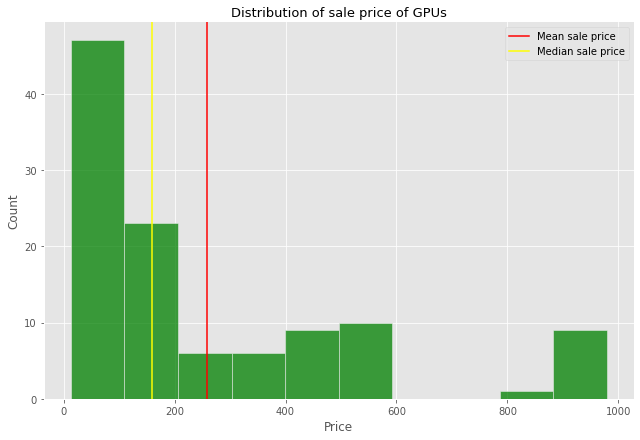

In [79]:
# plt.figure(figsize=(99,99))
sns.displot(GPU_df_no_reviews['Price'], bins=10, aspect=1.5, height=6, color='green')
plt.axvline(GPU_df_no_reviews['Price'].mean(),color='red')
plt.axvline(GPU_df_no_reviews['Price'].median(),color='yellow')

plt.title('Distribution of sale price of GPUs', size=13)
plt.legend(['Mean sale price','Median sale price']);

The distribution shows a right skewed graph with most of the GPUs falling below the 100 dollars range. The mean and the median prices are far part showing that they are some outliers in the price distribution as seen in the price range of 800 and 1000 dollars range. 

### Distribution of AMD and Nvidia Chipsets

In [80]:
GPU_df_no_reviews['Chipset Brand'].value_counts(normalize=True)

Nvidia    0.693694
Amd       0.306306
Name: Chipset Brand, dtype: float64

It seems that most of the GPUs are under Nvidia with a proportion of 70% while Amd has a proportion of 30%.

### Most popular brands by their rating

In [81]:
GPU_df_no_reviews['Manufacturer'].value_counts()

MSI                  26
Gigabyte             20
Asus                 17
EVGA                 16
VisionTek             6
XFX                   6
Zotac                 6
PowerColor            4
SAPPHIRE              2
Althon Micro Inc.     2
NVIDIA                2
Docooler              1
AMD                   1
Aiposen               1
ASRock                1
Name: Manufacturer, dtype: int64

As NVIDIA, NVIDIA Corporation and Althon Micro Inc. have only 1 GPUs, I'll not include them in the popular brand investigation

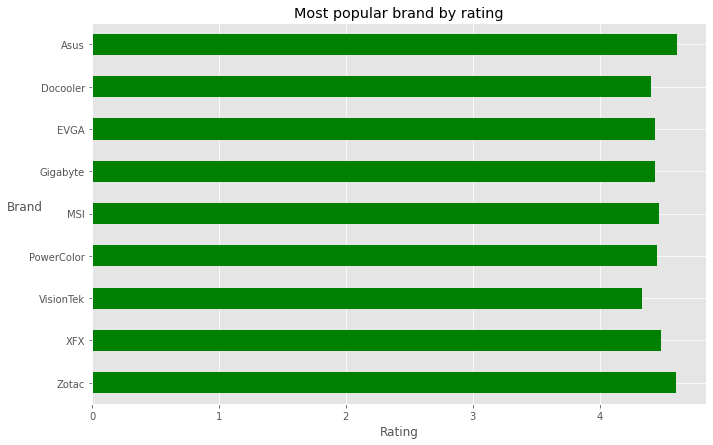

In [82]:
manufacturer_list = ['AMD','ASRock','Aiposen','SAPPHIRE', 'Althon Micro Inc.', 'NVIDIA']
GPU_df_no_reviews.groupby('Manufacturer').mean().drop(manufacturer_list)['Overall Customer Rating'].sort_index(ascending=False).plot(kind='barh', 
                                                                                                                                            title='Most popular brand by rating', 
                                                                                                                                            figsize=(11,7), 
                                                                                                                                            color='green')
plt.xlabel('Rating')
plt.ylabel('Brand', rotation=360);

In [83]:
GPU_df_no_reviews.groupby('Manufacturer').mean().drop(manufacturer_list)['Overall Customer Rating'].sort_values(ascending=False)

Manufacturer
Asus          4.605882
Zotac         4.600000
XFX           4.483333
MSI           4.469231
PowerColor    4.450000
EVGA          4.437500
Gigabyte      4.435000
Docooler      4.400000
VisionTek     4.333333
Name: Overall Customer Rating, dtype: float64

Without including Nvidia and Althon Micro Inc as they have only 1 type of GPU, Asus, EVGA and SAPPHIRE are the most popular brands given their high ratings.

The reason behind this is that consumers usually prefer 3rd party coolers fitted into the GPUs compared to the Nvidia's coolers as they're much more effective in controlling the airflow and decreasing the GPU temperature. 

### Which Chipset Brand has a higher customer rating?

In [84]:
GPU_df_no_reviews.groupby('Chipset Brand').mean()['Overall Customer Rating']

Chipset Brand
Amd       4.408824
Nvidia    4.494805
Name: Overall Customer Rating, dtype: float64

Nvidia is slightly ahead of AMD in terms of the Overall Customer rating.

### Which Manufacturer produces GPUs with higher Memory Speed and Size?

In [85]:
GPU_df_no_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GPU Name                 111 non-null    object 
 1   Manufacturer             111 non-null    object 
 2   Chipset Brand            111 non-null    object 
 3   Memory Speed(MHz)        111 non-null    float64
 4   Memory Size              111 non-null    object 
 5   Price                    111 non-null    float64
 6   Overall Customer Rating  111 non-null    float64
 7   isenglish                111 non-null    int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 7.1+ KB


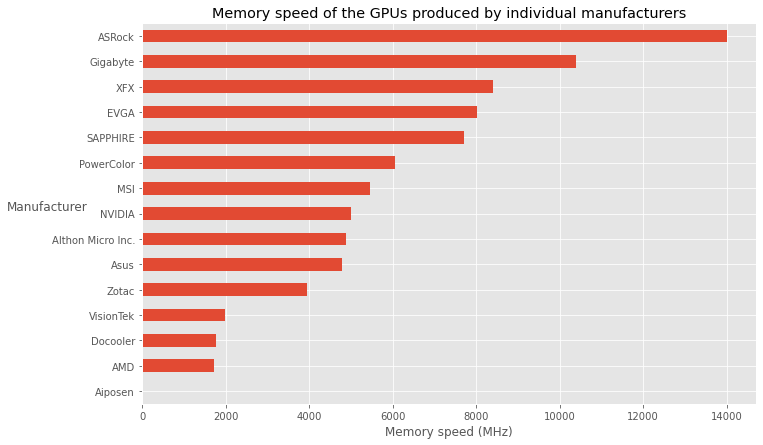

In [86]:
GPU_df_no_reviews.groupby('Manufacturer').mean()['Memory Speed(MHz)'].sort_values().plot(kind='barh', figsize=(11,7))

plt.title('Memory speed of the GPUs produced by individual manufacturers')
plt.xlabel('Memory speed (MHz)')
plt.ylabel('Manufacturer',rotation=360);

In [87]:
GPU_df_no_reviews.groupby('Manufacturer').mean()['Memory Speed(MHz)'].sort_values(ascending=False)

Manufacturer
ASRock               14000.000000
Gigabyte             10391.100000
XFX                   8397.666667
EVGA                  8011.562500
SAPPHIRE              7700.000000
PowerColor            6057.500000
MSI                   5458.192308
NVIDIA                5000.000000
Althon Micro Inc.     4879.000000
Asus                  4788.235294
Zotac                 3942.500000
VisionTek             1979.833333
Docooler              1770.000000
AMD                   1730.000000
Aiposen                  2.000000
Name: Memory Speed(MHz), dtype: float64

ASRock, Gigabyte, XFX and EVGA manufacturers produces GPUs with high amount of memory speed which shows that they're premium brands that produce 'Enthusiast Grade' types of GPUs.

### EDA on Customer Review Title

In [88]:
customer_review_title = " ".join(GPU_df['Customer Review Title'])

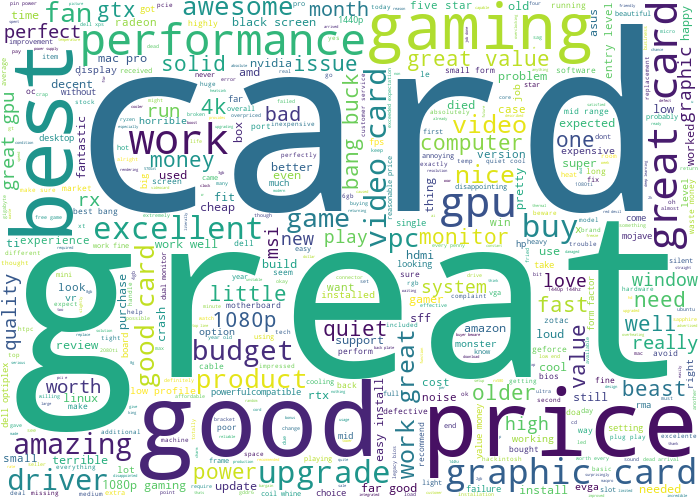

In [89]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, 
                      contour_width=5, contour_color='steelblue', width=700, height=500)
wordcloud.generate(customer_review_title)
# Visualize the word cloud
wordcloud.to_image()

Based on the word cloud, it seems that consumers are mostly satisfied with their GPU purchase with 'good', 'great' and 'best' words coming out at the top. The consumers are mostly gamers and most of them play in 1080p resolution and they seem to be price sensitive with the words such as 'bang buck' and 'great value' having a bigger size. 

In [90]:
customer_review_title_list = customer_review_title.split()
customer_review_title_dict = {}

for word in customer_review_title_list:
    if word not in customer_review_title_dict.keys():
        customer_review_title_dict[word] = customer_review_title_list.count(word)
    else:
        continue
        
customer_review_title_dict

{'change': 4,
 'card': 422,
 'default': 2,
 'setting': 8,
 '2019': 1,
 'gold': 1,
 'toilet': 1,
 'award': 1,
 'buy': 48,
 'awesome': 30,
 'cheap': 11,
 'xan': 1,
 'handle': 5,
 'anything': 3,
 '1080': 18,
 'budget': 38,
 'build': 16,
 'could': 6,
 'great': 324,
 'got': 8,
 '1603': 1,
 'error': 4,
 'decent': 14,
 '1080p': 41,
 'gaming': 92,
 'ok': 5,
 'fan': 34,
 'noise': 10,
 'oddly': 1,
 'missing': 5,
 '3rd': 1,
 'heat': 6,
 'pipe': 2,
 'horrifying': 1,
 'driver': 42,
 'make': 12,
 'nearly': 1,
 'impossible': 1,
 '4': 9,
 'display': 9,
 'needed': 15,
 'gpu': 89,
 'little': 22,
 'even': 12,
 'better': 14,
 'thought': 5,
 'tweakiing': 1,
 'well': 37,
 'worth': 23,
 'good': 166,
 'almost': 4,
 'caught': 1,
 'lot': 9,
 'memory': 2,
 'hear': 1,
 'thing': 11,
 'believe': 1,
 'something': 4,
 'like': 13,
 'scratched': 2,
 'box': 16,
 'oh': 5,
 'yeah': 2,
 'huge': 5,
 'alright': 4,
 'tight': 5,
 'best': 91,
 'entry': 12,
 'level': 19,
 'graphic': 80,
 'buck': 24,
 'died': 11,
 '6': 5,
 'month

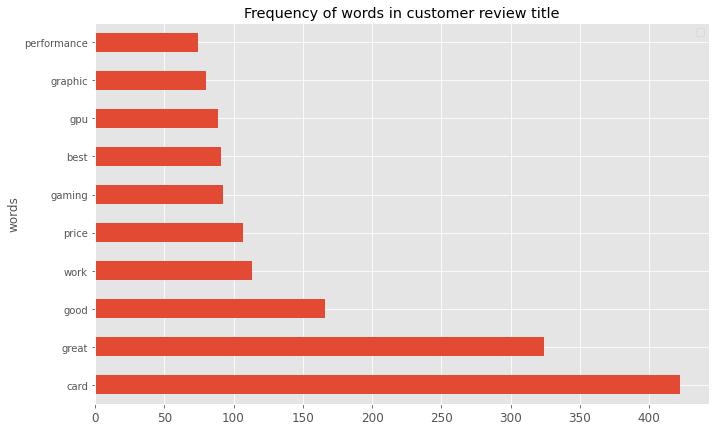

In [91]:
df = {'words': customer_review_title_dict.keys(), 'freq': customer_review_title_dict.values()}
customer_review_title_df = pd.DataFrame(df)
customer_review_title_df.sort_values('freq', ascending=False).set_index('words').head(10).plot(kind='barh', figsize=(11,7),
                                                                                              title='Frequency of words in customer review title')
plt.xticks(fontsize=12)
plt.legend([]);

The graph shows consistency with the word cloud on the frequency of the words appearing in the customer review title.

In [92]:
# customer_review_title_df['freq'].hist(bins=150)
# plt.xlim(0,50)

### EDA on Customer Review

In [93]:
customer_review = " ".join(GPU_df['Customer Review'])

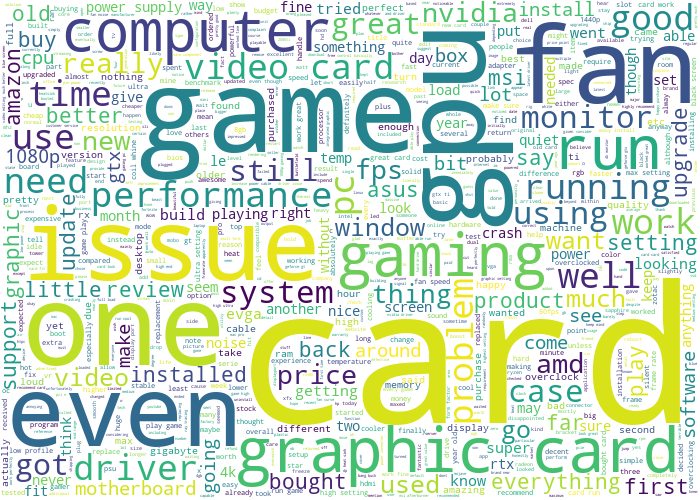

In [94]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, 
                      contour_width=5, contour_color='steelblue', width=700, height=500)
wordcloud.generate(customer_review)
# Visualize the word cloud
wordcloud.to_image()

Similar to the customer review title word cloud, consumers who purchase GPUs tend to be gamers and they play on 1080p resolution. GPU fans are an important factor when making a GPU purchase as the word 'fan' size is rather big. The word 'issue' and 'problem' shows up big which suggests that consumers may have encountered issues with the GPUs they have purchased. The two brands 'amd' and 'nvidia' shows that these 2 are the major players in the GPU market. GPU drivers seem to play an important role in making sure that the GPU is functioning.

In [95]:
customer_review_list = customer_review.split()
customer_review_dict = {}

for word in customer_review_list:
    if word not in customer_review_dict.keys():
        customer_review_dict[word] = customer_review_list.count(word)
    else:
        continue
        
customer_review_dict

{'using': 356,
 'geforce': 148,
 'last': 129,
 'card': 4904,
 'gtx': 367,
 '750': 38,
 'lately': 8,
 'software': 247,
 'irritating': 5,
 'causing': 22,
 'issue': 639,
 'whatnot': 2,
 'especially': 70,
 'come': 201,
 'recording': 15,
 'game': 1424,
 'hear': 94,
 'radeon': 130,
 'caught': 5,
 'graphic': 817,
 'day': 231,
 'decided': 67,
 'try': 114,
 'one': 819,
 'decent': 89,
 'kinda': 12,
 'wished': 2,
 'knew': 31,
 'ahead': 17,
 'time': 500,
 'could': 265,
 'easily': 82,
 'find': 128,
 'wrong': 56,
 'chance': 18,
 'reason': 98,
 'giving': 39,
 '5': 302,
 'star': 162,
 'infuriating': 3,
 'figure': 21,
 'answer': 21,
 'place': 40,
 'default': 50,
 'setting': 782,
 'cause': 57,
 'various': 22,
 'problem': 396,
 'change': 65,
 'via': 42,
 'amd': 451,
 'wattman': 15,
 'whatever': 30,
 'want': 285,
 'use': 400,
 'case': 467,
 'everything': 283,
 'installed': 291,
 'fine': 247,
 'tell': 64,
 'first': 282,
 'running': 423,
 'okay': 33,
 'launched': 8,
 'monster': 24,
 'hunter': 9,
 'world': 5

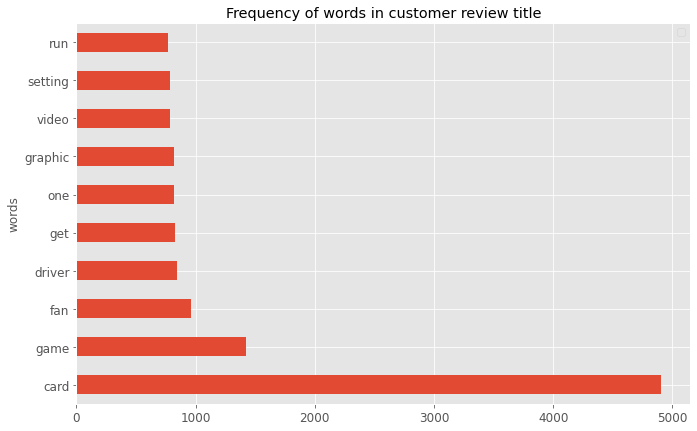

In [96]:
review_df = {'words': customer_review_dict.keys(), 'freq': customer_review_dict.values()}
customer_review_df = pd.DataFrame(review_df)
customer_review_df.sort_values('freq', ascending=False).set_index('words').head(10).plot(kind='barh', figsize=(11,7),
                                                                                              title='Frequency of words in customer review title')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend([]);

The graph shows consistency with the word cloud on the frequency of the words appearing in the customer review title.

## Prepare data for LDA Analysis

I'll be using only Customer Review to conduct the LDA Analysis as it makes up the bulk of the words.

In [97]:
# Converting to the customer reviews from series to a list.
data = GPU_df['Customer Review'].values.tolist()
data[600]

'easy physically install instruction failed mention bios monitor work first booted plugged new card pressed delete time hoping computer would open bios could shut plug back onboard video card enter bios disable onboard video default pcie slot business someone familiar bios might suspect card work forget change bios use onboard video card install card got past hiccup fine'

In [98]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sentence))

In [99]:
texts = list(sent_to_words(data))

In [100]:
# Prints the first document with up to 30 words in them
print(texts[:1][0][:30])

['using', 'geforce', 'last', 'card', 'gtx', 'lately', 'software', 'irritating', 'causing', 'issue', 'whatnot', 'especially', 'come', 'recording', 'game', 'hear', 'radeon', 'caught', 'graphic', 'card', 'day', 'decided', 'try', 'one', 'decent', 'card', 'kinda', 'wished', 'knew', 'ahead']


In [101]:
# Create Dictionary
id2word = corpora.Dictionary(texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 12), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 2), (22, 2), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


## LDA Model Training

In [102]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"card" + 0.012*"game" + 0.010*"fan" + 0.007*"run" + 0.006*"great" + '
  '0.006*"like" + 0.006*"good" + 0.006*"also" + 0.006*"power" + '
  '0.005*"setting"'),
 (1,
  '0.028*"card" + 0.012*"run" + 0.010*"game" + 0.008*"fps" + 0.007*"get" + '
  '0.007*"fan" + 0.007*"gaming" + 0.007*"setting" + 0.006*"gpu" + '
  '0.006*"issue"'),
 (2,
  '0.041*"card" + 0.011*"driver" + 0.009*"get" + 0.008*"power" + '
  '0.007*"graphic" + 0.007*"work" + 0.006*"one" + 0.006*"good" + 0.005*"pc" + '
  '0.005*"fan"'),
 (3,
  '0.030*"card" + 0.012*"game" + 0.011*"gpu" + 0.011*"fan" + 0.009*"graphic" + '
  '0.008*"video" + 0.007*"one" + 0.006*"fps" + 0.006*"setting" + 0.006*"get"'),
 (4,
  '0.018*"card" + 0.009*"video" + 0.009*"monitor" + 0.008*"gpu" + '
  '0.008*"graphic" + 0.008*"game" + 0.007*"driver" + 0.007*"work" + '
  '0.007*"one" + 0.006*"power"'),
 (5,
  '0.033*"card" + 0.007*"driver" + 0.006*"power" + 0.006*"great" + '
  '0.006*"would" + 0.006*"gpu" + 0.005*"fan" + 0.005*"msi" + 0.005*"run

In [103]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+'ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if False:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, os.getcwd()+ '\\visualization\\' + 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.009701 -0.012400       1        1  25.100069
9      0.004393 -0.011183       2        1  16.223855
6      0.009262 -0.006597       3        1  12.630738
0      0.003570  0.003860       4        1  10.721018
1      0.008150  0.014571       5        1  10.420414
2      0.010363  0.006610       6        1   7.301777
4      0.011594  0.024526       7        1   7.164593
3     -0.000702 -0.026288       8        1   3.985712
5     -0.015439  0.000351       9        1   3.569680
8     -0.040892  0.006552      10        1   2.882144, topic_info=        Term         Freq        Total Category  logprob  loglift
10      card  4654.000000  4654.000000  Default  30.0000  30.0000
180   driver   765.000000   765.000000  Default  29.0000  29.0000
257      fan   908.000000   908.000000  Default  28.0000  28.0000
115  setting   732.000000   732.000000  Default  27.0000  27.0000
63     issue   586.000000   586.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
132     time    13.084542   477.671736  Topic10  -5.6250  -0.0509
48      game    19.045810  1409.413565  Topic10  -5.2496  -0.7574
63     issue    13.381423   586.655933  Topic10  -5.6026  -0.2339
55   graphic    12.948862   792.797686  Topic10  -5.6354  -0.5679
86       one    12.694043   800.593640  Topic10  -5.6553  -0.5976

[826 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
7547      3  0.549658       aceptable
6013      8  0.687806  acknowledgment
7719      3  0.549561      activating
3994      1  0.231431         adaptor
3994      2  0.115716         adaptor
...     ...       ...             ...
593       9  0.047690             yet
593      10  0.019076             yet
5675      1  0.909213              yo
6849      6  0.609861             zen
2147      9  0.680875              zi

[2108 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 7, 1, 2, 3, 5, 4, 6, 9])

# Others

## Testing function (Working for now)

In [104]:
# #def scrape_gpu(no_page, no_gpu, no_review_page):

# # Create the Chrome Driver object
# driver = webdriver.Chrome()

# # Id for GPU tracking
# ids = 1

# # To keep track of the last entry appended for the review titles and body and the rating
# idx_title = 0
# idx_body = 0
# idx_star = 0
# #print('Over sas')

# for page in range(1,3):
#     # Gets the first page of the website
#     #print('Over ss')
#     driver.get(f'https://www.amazon.com/s?k=Computer+Graphics+Cards&i=computers&rh=n:284822&page={page}&_encoding=UTF8&c=ts&qid=1608032958&ts_id=284822')
#     main_url = driver.current_url
#     #print('Over here')

#     # # Check for sponsored post
#     sponsored_posts = driver.find_elements_by_xpath('//div[@data-component-type="sp-sponsored-result"]/../../../..')
#     lst_index_sponsored = []
#     # Loop through the sponsored posts to find the index of the sponsored product
#     for post in sponsored_posts:
#         lst_index_sponsored.append(int(post.get_attribute('data-index')))

#     n = 0 # index number

#     # Scrap 3 GPUs in the first page
#     while n < 3:

#         # If the index is in sponsored list
#         while n in lst_index_sponsored:
#             print(f'{n} index is a Sponsored Product, will skip to the next product')
#             n += 1

#         # Wait for 1 seconds
#         time.sleep(1)
        
#         try:
#             # Click the link for the nth GPU
#             driver.find_element_by_xpath(f'//div[@data-index={str(n)}]//a[@class="a-link-normal a-text-normal"]').click()
#         except NoSuchElementException:
#             break

#         # Gets the url of the main page of the GPU
#         gpu_url = driver.current_url

#         # Click on the "See all reviews" link
#         try:
#             driver.find_element_by_xpath('//a[@data-hook="see-all-reviews-link-foot"]').click()
#         except NoSuchElementException:
#             n += 1
#             # Go back to the main page
#             driver.get(main_url)
#             continue # Go back to the start of the while loop

#         # Wait for 1 seconds
#         time.sleep(1)


#         """
#         Loop through the review page and obtain the review title, review body, ratings
#         """

#         # Number of review pages to loop through for each GPU
#         for review_page in range(2):

#             # Gets the title of the reviews for each page, selects only the first span if there are multiple spans
#             title_comment = driver.find_elements_by_xpath('//*[@data-hook = "review-title"]/span[1]')

#             # Gets the customer reviews for each page
#             review_body = driver.find_elements_by_xpath('//*[@data-hook = "review-body"]')


#             # Loop through the title comments and append it to the Customer Review Title
#             for title in title_comment:
#                 GPU_df.loc[idx_title, 'Customer Review Title'] = title.text
#                 idx_title += 1
#                 #print(f'Customer review title is {title.text}')

#             # Gets the review_bodies in the page and stores them in a list
#             review_list = [review.text for review in review_body]


#             # Loop through the review comments and append it to the Customer Review
#             for review in review_list:
#                 GPU_df.loc[idx_body, 'Customer Review'] = review
#                 idx_body += 1

#             # Sleep
#             time.sleep(1)

#             # Goes to the next review page   
#             try:
#                 driver.find_element_by_xpath('//li[@class="a-last"]/a').click()
#                 # Sleep
#                 time.sleep(3)
#             # If not break out of the loop, and go back to the GPU main page
#             except NoSuchElementException:
#                 break




#         """
#         Fill up the null values with their respective attributes
#         """

#         # Go back to the GPU main page
#         driver.get(gpu_url)

#         # Wait for 2 seconds
#         time.sleep(2)

#         # Fill up the null values with the GPU name
#         GPU_df['GPU Name'].fillna(driver.find_element_by_xpath('//*[@id="productTitle"]').text, inplace=True)

#         # Fill up the null values with the Chipset Brand
#         try:
#             chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Chipset Brand")]/../../td').text
#             GPU_df['Chipset Brand'].fillna(chipset,inplace=True)
#         except NoSuchElementException:
#             GPU_df['Chipset Brand'].fillna(np.nan,inplace=True)

#         # Fill up the null values with the Memory Size
#         try:
#             chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Graphics Card Ram Size")]/../../td').text
#             GPU_df['Memory Size'].fillna(chipset,inplace=True)
#         except NoSuchElementException:
#             GPU_df['Memory Size'].fillna(np.nan,inplace=True)

#         # Fill up the null values with the Memory Speed(MHz)
#         try:
#             chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Memory Speed")]/../../td').text
#             GPU_df['Memory Speed(MHz)'].fillna(chipset,inplace=True)
#         except NoSuchElementException:
#             GPU_df['Memory Speed(MHz)'].fillna(np.nan,inplace=True)

#         # Fill up the null values with the manufacturer name
#         try:
#             manufacturer = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_2"]/tbody//th[contains(text(),"Manufacturer")]/../td').text
#             GPU_df['Manufacturer'].fillna(manufacturer, inplace=True)
#         except NoSuchElementException:
#             GPU_df['Manufacturer'].fillna(np.nan,inplace=True)

#         # Fill up the null values with the Price
#         try:
#             GPU_df['Price'].fillna(driver.find_element_by_xpath('//*[@id="price_inside_buybox"]').text, inplace=True)
#         except NoSuchElementException:
#              GPU_df['Price'].fillna(np.nan, inplace=True)

#         # Fill up the null values with the Customer ratings
#         try:
#             # Gets the overall customer ratings
#             GPU_df['Overall Customer Rating'].fillna(driver.find_element_by_xpath('//div[@id="averageCustomerReviews"]//span[@id="acrPopover"]').get_attribute('title'), inplace=True)
#         except NoSuchElementException:
#             GPU_df['Overall Customer Rating'].fillna(np.nan, inplace=True)

#         # Fill the id of the GPU for tracking
#         GPU_df['id'].fillna(ids,inplace=True)
#         ids += 1

#         print(f'Completed scraping for {n} index in page {page}')

#         # Increases the index for the next GPU
#         n += 1

#         # Go back to the main page
#         driver.get(main_url)

#     print('*'*30)
#     print(f'Completed scraping for page {page}')
#     print('*'*30)

# # Close the browser session
# total_gpu = max(GPU_df['id'])
# print(f'Completed scraping {total_gpu} GPUs reviews for {page} pages')
# driver.quit()

# Testing the review body for the page

In [105]:
# # Testing the review body for the page


# # Create the Chrome Driver object
# driver = webdriver.Chrome() 
# driver.get('https://www.amazon.com/Gigabyte-Radeon-Gaming-Graphic-GV-RX580GAMING-8GD/product-reviews/B0842VMKM5/ref=cm_cr_getr_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=2')

# # Count the number of Spans in the "Review Body" class, if more than 1, put it in a list and use "".join()
# # before appending it to the dataframe
# more_than_1 = driver.find_elements_by_xpath('///span[@data-hook="review-body"][count(./span) > 1]/span')
# review_body = driver.find_elements_by_xpath('//*[@data-hook = "review-body"]/span')

# # If there is a review that is split into multiples span
# if more_than_1: 
#     # Holds the list of reviews
#     review_list = []
#     for review in more_than_1:
#         review_list.append(review.text) # Append it into a list
#     GPU_df.loc[idx_body, 'Customer Review'] = "".join(review_list)
#     idx_body += 1
#     for review in review_body[len(more_than_3)+1:]: # Reviews with one span
#         GPU_df.loc[idx_body, 'Customer Review'] = review.text
#         idx_body += 1
# else:
#     # Loop through the review comments and append it to the Customer Review
#     for review in review_body:
#         GPU_df.loc[idx_body, 'Customer Review'] = review.text
#         idx_body += 1
    
        
# # Wait for 2 seconds
# time.sleep(2)
# driver.quit()

## Testing the review body using for loop

In [106]:
# # Testing the review body for the page


# # Create the Chrome Driver object
# driver = webdriver.Chrome() 
# driver.get('https://www.amazon.com/MSI-GT-710-2GD3-LP/product-reviews/B01DOFD0G8/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews')


# review_body = driver.find_elements_by_xpath('//*[@data-hook = "review-body"]/span')

# # Get all the reviews 
# reviews = driver.find_elements_by_xpath('//span[@data-hook="review-body"]')
# review_list = [x.text for x in reviews]
# print([x.text for x in reviews])

# for review in review_list:
#     GPU_df.loc[idx_body, 'Customer Review'] = review
#     idx_body += 1
            
# # Wait for 2 seconds
# time.sleep(2)
# driver.quit()

In [107]:
# review_list[2]

In [108]:
# GPU_df

In [109]:
# GPU_df['Customer Review'].loc[41]

# Testing the star ratings of the comment for the page

In [110]:
# # Testing the star ratings of the comment for the page

# # Holds the list of reviews
# list_of_stars = []

# # Create the Chrome Driver object
# driver = webdriver.Chrome() 
# driver.get('https://www.amazon.com/XFX-Radeon-1386MHz-Graphics-RX-580P8DFD6/dp/B06Y66K3XD/ref=cm_cr_arp_d_bdcrb_top?ie=UTF8&th=1')


# star_ratings = driver.find_element_by_xpath('//div[@id="averageCustomerReviews"]//span[@id="acrPopover"]').get_attribute('title')

# # Get the Profile name 
# # star_ratings = driver.find_elements_by_xpath('//div[@data-hook="review"]//span[@class= "a-profile-name"]')


# # For individual customer reviews
# # for star in star_ratings:
# #     list_of_stars.append(star.get_attribute('title'))
    
# # Wait for 2 seconds
# time.sleep(2)
# driver.quit()

In [111]:
# star_ratings

In [112]:
# GPU_df.loc[6] = ['','','','','','']
# GPU_df.loc[7]